# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra, Mihir Suvarna, Daniel Sialm

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Due to the increasing importance of the task of text recognition, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Dataset

In [2]:
letter_to_label = dict()
classes_collected = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes_collected)):
    letter_to_label[classes_collected[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [3]:
import os
import shutil
import glob

from PIL import Image
import torchvision.transforms as transforms

src_dir = 'dataset'
transform = transforms.ToTensor()

files_train = []
files_val = []
files_test = []
for i in range(0,16): files_train.append('P' + str(i))
for i in range(16,21): files_val.append('P' + str(i))
for i in range(21,24): files_test.append('P' + str(i))

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    file = ftitle.split("_")[0].split("-")[0]
    im = Image.open(f).convert('L')

    if file in files_train:
        imgs_train.append(transform(im).detach().numpy())
        labels_train.append(letter_to_label[letter])
    elif file in files_val:
        imgs_val.append(transform(im).detach().numpy())
        labels_val.append(letter_to_label[letter])
    elif file in files_test:
        imgs_test.append(transform(im).detach().numpy())
        labels_test.append(letter_to_label[letter])
    
data_train = torch.tensor(imgs_train)
data_val = torch.tensor(imgs_val)
data_test = torch.tensor(imgs_test)
labels_train = torch.tensor(np.array(labels_train))
labels_val = torch.tensor(np.array(labels_val))
labels_test = torch.tensor(np.array(labels_test))

print(data_train.shape, data_val.shape, data_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

torch.Size([4160, 1, 28, 28]) torch.Size([1300, 1, 28, 28]) torch.Size([780, 1, 28, 28])
torch.Size([4160]) torch.Size([1300]) torch.Size([780])


/var/folders/k7/zz5h09l90lz91rrnxkcsyfv00000gn/T/ipykernel_93330/2075399133.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/torch/csrc/utils/tensor_new.cpp:201.)
  data_train = torch.tensor(imgs_train)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: m


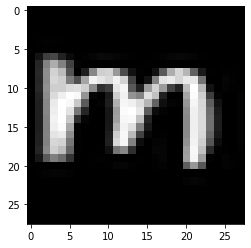

In [4]:
# Data visualization

# print classes
print(classes_collected)
# print label
index = 125
plt.imshow(data_train[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels_train[index].item()])

In [5]:
batch_size = 64

train_set_collected = torch.utils.data.TensorDataset(data_train, labels_train)
val_set_collected = torch.utils.data.TensorDataset(data_val, labels_val)
test_set_collected = torch.utils.data.TensorDataset(data_test, labels_test)

train_loader_collected = torch.utils.data.DataLoader(train_set_collected, batch_size=batch_size, shuffle=True)
val_loader_collected = torch.utils.data.DataLoader(val_set_collected, batch_size=batch_size, shuffle=True)
test_loader_collected = torch.utils.data.DataLoader(test_set_collected, batch_size=batch_size, shuffle=True)

## Defining a basic LetterCNN

In [6]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [7]:
# Testing the model above, TODO remove before submission
model_test = letterCNN(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


## Testing the basic LetterCNN

In [8]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                labels = labels.type(torch.long)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    labels = labels.type(torch.long)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model.forward(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

def display_contingency_matrix(num_classes, pred, true):
    contingency = np.zeros((num_classes, num_classes))
    for i in range(len(pred)):
        contingency[int(pred[i])][int(true[i])] += 1

    plt.matshow(contingency)
    plt.xlabel("true")
    plt.ylabel("predictions")
    plt.colorbar()

In [9]:
model1 = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
train_network(model1, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.46389
   Val loss: 2.25270

EPOCH 1
 Train loss: 1.06633
   Val loss: 2.06901

EPOCH 2
 Train loss: 0.63415
   Val loss: 2.21673

EPOCH 3
 Train loss: 0.41168
   Val loss: 2.47645

EPOCH 4
 Train loss: 0.27200
   Val loss: 2.60582

EPOCH 5
 Train loss: 0.18244
   Val loss: 2.79084

EPOCH 6
 Train loss: 0.12559
   Val loss: 2.98147

EPOCH 7
 Train loss: 0.09063
   Val loss: 3.16806

EPOCH 8
 Train loss: 0.06437
   Val loss: 3.34533

EPOCH 9
 Train loss: 0.04861
   Val loss: 3.39470



Test accuracy: 50.000


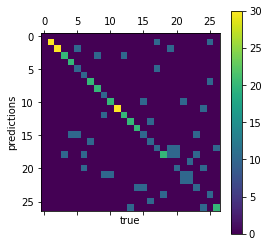

In [10]:
acc, true, pred = test_network(model1, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1.classes), pred, true)

We can see that there is quite a bit of overfitting going on (val loss is not converging). Also, our accuracy is quite low. While this accuracy is still quite good - $48.718 / (1 / 26) = 12.67$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained which. This ends up heavily overrepresenting our training dataset towards the handwriting of a few people. Consequently, our model does not generalize well. We can also see this from the increasing validation loss. 

Thus, we will combine our dataset with the EMNIST dataset to create a better model.

### EMNIST Data Set

In [11]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.78*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [13]:
# initialize the data sets
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


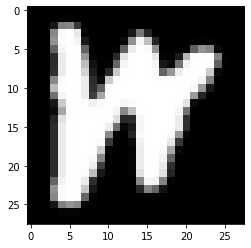

In [14]:
# Visualizing EMNIST

# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

### Combining EMNIST with our Data

In [56]:
combined_batch_size=64

combined_train = []
combined_train_labels = []
combined_val = []
combined_val_labels = []
combined_test = []
combined_test_labels = []

for inputs, labels in train_loader:
    combined_train.append(inputs[0].detach().transpose(1, 2).numpy())
    combined_train_labels.append( labels[0].item() )
for inputs, labels in train_loader_collected:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
        
for inputs, labels in val_loader:
    combined_val.append( inputs[0].detach().transpose(1, 2).numpy() )
    combined_val_labels.append( labels[0].item() )
for inputs, labels in val_loader_collected:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
        
for inputs, labels in test_loader:
    combined_test.append( inputs[0].detach().transpose(1, 2).numpy() )
    combined_test_labels.append( labels[0].item() )
for inputs, labels in test_loader_collected:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )

combined_train = np.array(combined_train)
combined_train_labels = np.array(combined_train_labels)
combined_val = np.array(combined_val)
combined_val_labels = np.array(combined_val_labels)
combined_test = np.array(combined_test)
combined_test_labels = np.array(combined_test_labels)

print(combined_train.shape)
print(combined_train_labels.shape)
print(combined_val.shape)
print(combined_val_labels.shape)
print(combined_test.shape)
print(combined_test_labels.shape)

combined_train = torch.Tensor(combined_train)
combined_train_labels = torch.Tensor(combined_train_labels)

combined_val = torch.Tensor(combined_val)
combined_val_labels = torch.Tensor(combined_val_labels)

combined_test = torch.Tensor(combined_test)
combined_test_labels = torch.Tensor(combined_test_labels)


cobined_train_set = torch.utils.data.TensorDataset(combined_train, combined_train_labels)
combined_train_loader = torch.utils.data.DataLoader(cobined_train_set, batch_size=combined_batch_size, shuffle=True)

cobined_val_set = torch.utils.data.TensorDataset(combined_val, combined_val_labels)
combined_val_loader = torch.utils.data.DataLoader(cobined_val_set, batch_size=combined_batch_size, shuffle=True)

cobined_test_set = torch.utils.data.TensorDataset(combined_test, combined_test_labels)
combined_test_loader = torch.utils.data.DataLoader(cobined_test_set, batch_size=combined_batch_size, shuffle=True)

print(len(combined_train_loader))
print(len(combined_val_loader))
print(len(combined_test_loader))

(50960, 1, 28, 28)
(50960,)
(14500, 1, 28, 28)
(14500,)
(21580, 1, 28, 28)
(21580,)
797
227
338


torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
Label: z


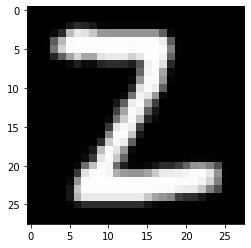

In [54]:
# Have to transpose EMNIST data, TODO remove before submission
for inputs, labels in train_loader:
    transposed = inputs[0].transpose(1, 2)
    print(inputs.shape)
    print(reshaped.shape)
    plt.imshow(transposed.reshape((28, 28)), cmap='Greys_r')
    print("Label: %s" % classes_collected[labels[0]])
    break

## Making a new LetterCNN on the Combined Dataset

In [57]:
model2 = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
train_network(model2, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.10117
   Val loss: 0.77232

EPOCH 1
 Train loss: 0.57291
   Val loss: 0.63014

EPOCH 2
 Train loss: 0.47475
   Val loss: 0.60114

EPOCH 3
 Train loss: 0.42264
   Val loss: 0.58191

EPOCH 4
 Train loss: 0.38892
   Val loss: 0.56999

EPOCH 5
 Train loss: 0.36029
   Val loss: 0.57006

EPOCH 6
 Train loss: 0.33827
   Val loss: 0.56202

EPOCH 7
 Train loss: 0.31945
   Val loss: 0.59260

EPOCH 8
 Train loss: 0.30436
   Val loss: 0.56047

EPOCH 9
 Train loss: 0.28885
   Val loss: 0.56484



Test accuracy: 86.840


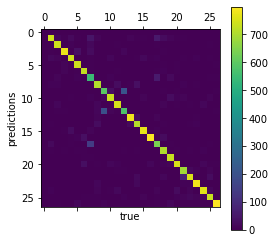

In [58]:
acc, true, pred = test_network(model2, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model2.classes), pred, true)

We not get much better resuls. __TODO Explain more__

## Computational Experiment 1 - Regularization

### 1a) Regularization through data augmentation

In [18]:
src_dir = "dataset_digital"
idx = 0

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    im = Image.open(f).convert('L')

    if idx < 1820:
        imgs_train.append(transform(im).detach().numpy())
        labels_train.append(letter_to_label[letter])
    elif idx < 2210:
        imgs_val.append(transform(im).detach().numpy())
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test.append(transform(im).detach().numpy())
        labels_test.append(letter_to_label[letter])
    
    idx += 1
        
data_train = torch.tensor(imgs_train)
data_val = torch.tensor(imgs_val)
data_test = torch.tensor(imgs_test)
labels_train = torch.tensor(np.array(labels_train))
labels_val = torch.tensor(np.array(labels_val))
labels_test = torch.tensor(np.array(labels_test))

print(data_train.shape, data_val.shape, data_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

torch.Size([1820, 1, 28, 28]) torch.Size([390, 1, 28, 28]) torch.Size([468, 1, 28, 28])
torch.Size([1820]) torch.Size([390]) torch.Size([468])


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: q


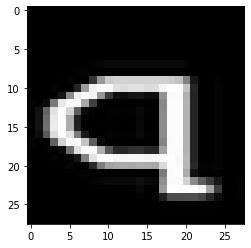

In [19]:
# Data visualization

# print classes
print(classes_collected)
# print label
index = 125
plt.imshow(data_train[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels_train[index].item()])

In [20]:
batch_size = 64

train_set_digital = torch.utils.data.TensorDataset(data_train, labels_train)
val_set_digital = torch.utils.data.TensorDataset(data_val, labels_val)
test_set_digital = torch.utils.data.TensorDataset(data_test, labels_test)

train_loader_digital = torch.utils.data.DataLoader(train_set_digital, batch_size=batch_size, shuffle=True)
val_loader_digital = torch.utils.data.DataLoader(val_set_digital, batch_size=batch_size, shuffle=True)
test_loader_digital = torch.utils.data.DataLoader(test_set_digital, batch_size=batch_size, shuffle=True)

In [21]:
combined_batch_size=64

combined_train = []
combined_train_labels = []
combined_val = []
combined_val_labels = []
combined_test = []
combined_test_labels = []

for inputs, labels in combined_train_loader:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
for inputs, labels in train_loader_digital:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
        
for inputs, labels in combined_val_loader:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
for inputs, labels in val_loader_digital:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
        
for inputs, labels in combined_test_loader:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )
for inputs, labels in test_loader_digital:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )

combined_train = np.array(combined_train)
combined_train_labels = np.array(combined_train_labels)
combined_val = np.array(combined_val)
combined_val_labels = np.array(combined_val_labels)
combined_test = np.array(combined_test)
combined_test_labels = np.array(combined_test_labels)

print(combined_train.shape)
print(combined_train_labels.shape)
print(combined_val.shape)
print(combined_val_labels.shape)
print(combined_test.shape)
print(combined_test_labels.shape)

combined_train = torch.Tensor(combined_train)
combined_train_labels = torch.Tensor(combined_train_labels)

combined_val = torch.Tensor(combined_val)
combined_val_labels = torch.Tensor(combined_val_labels)

combined_test = torch.Tensor(combined_test)
combined_test_labels = torch.Tensor(combined_test_labels)

cobined_train_set = torch.utils.data.TensorDataset(combined_train, combined_train_labels)
combined_train_digital_loader = torch.utils.data.DataLoader(cobined_train_set, batch_size=combined_batch_size, shuffle=True)

cobined_val_set = torch.utils.data.TensorDataset(combined_val, combined_val_labels)
combined_val_digital_loader = torch.utils.data.DataLoader(cobined_val_set, batch_size=combined_batch_size, shuffle=True)

cobined_test_set = torch.utils.data.TensorDataset(combined_test, combined_test_labels)
combined_test_digital_loader = torch.utils.data.DataLoader(cobined_test_set, batch_size=combined_batch_size, shuffle=True)

print(len(combined_train_digital_loader))
print(len(combined_val_digital_loader))
print(len(combined_test_digital_loader))

(52780, 1, 28, 28)
(52780,)
(14890, 1, 28, 28)
(14890,)
(22048, 1, 28, 28)
(22048,)
825
233
345


In [22]:
model_digital = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digital.parameters(), lr=1e-3)
train_network(model_digital, combined_train_digital_loader, combined_val_digital_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.32902
   Val loss: 1.01680

EPOCH 1
 Train loss: 0.81047
   Val loss: 0.80461

EPOCH 2
 Train loss: 0.63890
   Val loss: 0.74188

EPOCH 3
 Train loss: 0.55516
   Val loss: 0.68891

EPOCH 4
 Train loss: 0.50285
   Val loss: 0.68481

EPOCH 5
 Train loss: 0.46830
   Val loss: 0.66367

EPOCH 6
 Train loss: 0.44037
   Val loss: 0.65087

EPOCH 7
 Train loss: 0.41845
   Val loss: 0.66087

EPOCH 8
 Train loss: 0.40094
   Val loss: 0.65117

EPOCH 9
 Train loss: 0.38579
   Val loss: 0.63848



Test accuracy: 84.389


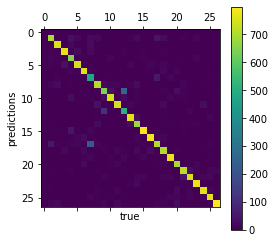

In [23]:
acc, true, pred = test_network(model_digital, combined_test_digital_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_digital.classes), pred, true)

### 1b) Regularization through dropout

In [24]:
class letterCNNDropout(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [25]:
# Testing the model above, TODO remove before submission
model_test = letterCNNDropout(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


In [26]:
model_dropout = letterCNNDropout(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)
train_network(model_dropout, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.37806
   Val loss: 1.12553

EPOCH 1
 Train loss: 0.90594
   Val loss: 0.89992

EPOCH 2
 Train loss: 0.71347
   Val loss: 0.79377

EPOCH 3
 Train loss: 0.62013
   Val loss: 0.75297

EPOCH 4
 Train loss: 0.56145
   Val loss: 0.73960

EPOCH 5
 Train loss: 0.52276
   Val loss: 0.74188

EPOCH 6
 Train loss: 0.49501
   Val loss: 0.71404

EPOCH 7
 Train loss: 0.47344
   Val loss: 0.71624

EPOCH 8
 Train loss: 0.45751
   Val loss: 0.69782

EPOCH 9
 Train loss: 0.44380
   Val loss: 0.70611



Test accuracy: 83.452


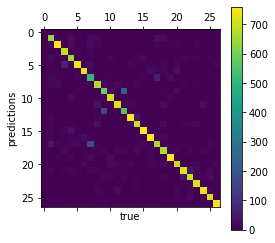

In [27]:
acc, true, pred = test_network(model_dropout, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_dropout.classes), pred, true)

### 1c) Regularization through Average Pooling

In [28]:
class letterCNNAvgPool(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [29]:
# Testing the model above, TODO remove before submission
model_test = letterCNNAvgPool(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


In [30]:
model_avgpool = letterCNNAvgPool(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_avgpool.parameters(), lr=1e-3)
train_network(model_avgpool, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.38918
   Val loss: 1.12753

EPOCH 1
 Train loss: 0.86343
   Val loss: 0.88396

EPOCH 2
 Train loss: 0.66005
   Val loss: 0.81155

EPOCH 3
 Train loss: 0.56962
   Val loss: 0.82044

EPOCH 4
 Train loss: 0.51609
   Val loss: 0.77599

EPOCH 5
 Train loss: 0.47788
   Val loss: 0.78290

EPOCH 6
 Train loss: 0.45065
   Val loss: 0.78576

EPOCH 7
 Train loss: 0.42875
   Val loss: 0.79060

EPOCH 8
 Train loss: 0.41146
   Val loss: 0.79463

EPOCH 9
 Train loss: 0.39469
   Val loss: 0.79261



Test accuracy: 83.545


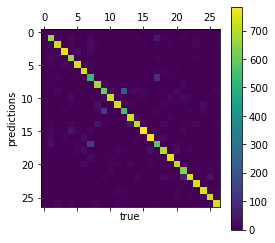

In [31]:
acc, true, pred = test_network(model_avgpool, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_avgpool.classes), pred, true)

### 1d) Regularization through Early Stopping

In [32]:
def train_network_early_stopping(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    prev_val_losses = [0] * 5
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                labels = labels.type(torch.long)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    labels = labels.type(torch.long)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                prev_val_losses[epoch % 5] = total_loss/count
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            if epoch > 5:
                prev_error_mean = sum(prev_val_losses) / len(prev_val_losses)
                if prev_error_mean > 0.80:
                    # implementing early stopping for regularization
                    # note that 0.65 here is a hyperparameter
                    print('Early stopping in epoch ' + str(epoch) + ' because the average of last 5 validation error was ' + str(prev_error_mean))
                    break
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

In [33]:
model_early_stopping = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_early_stopping.parameters(), lr=1e-3)
train_network_early_stopping(model_early_stopping, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.29758
   Val loss: 0.98479

EPOCH 1
 Train loss: 0.78706
   Val loss: 0.81062

EPOCH 2
 Train loss: 0.61809
   Val loss: 0.74506

EPOCH 3
 Train loss: 0.53201
   Val loss: 0.72210

EPOCH 4
 Train loss: 0.47997
   Val loss: 0.71829

EPOCH 5
 Train loss: 0.44394
   Val loss: 0.67209

EPOCH 6
 Train loss: 0.41118
   Val loss: 0.68281

EPOCH 7
 Train loss: 0.38469
   Val loss: 0.67321

EPOCH 8
 Train loss: 0.36447
   Val loss: 0.67194

EPOCH 9
 Train loss: 0.34570
   Val loss: 0.67120

EPOCH 10
 Train loss: 0.32767
   Val loss: 0.65699

EPOCH 11
 Train loss: 0.31586
   Val loss: 0.66706

EPOCH 12
 Train loss: 0.30278
   Val loss: 0.68427

EPOCH 13
 Train loss: 0.29274
   Val loss: 0.66737

EPOCH 14
 Train loss: 0.28255
   Val loss: 0.68196

EPOCH 15
 Train loss: 0.27232
   Val loss: 0.67299

EPOCH 16
 Train loss: 0.26365
   Val loss: 0.69368

EPOCH 17
 Train loss: 0.25783
   Val loss: 0.70119

EPOCH 18
 Train loss: 0.25067
   Val loss: 0.69369

EPOCH 19
 Train loss: 

Test accuracy: 85.375


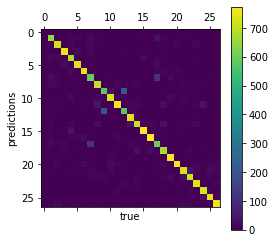

In [34]:
acc, true, pred = test_network(model_early_stopping, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_early_stopping.classes), pred, true)

## Computational Experiment 2 - Architecture

### 2a) Double Convolutional Layer

[]

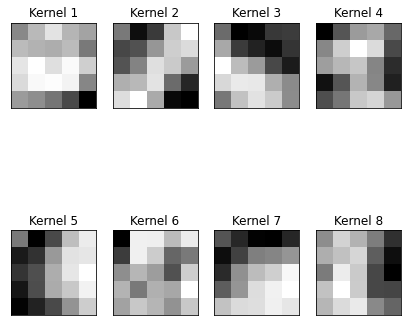

In [35]:
# first, extract the weights from the learned model
conv1wt = model2.layers[0].weight.data.numpy()

# then, visualize them!
_, axes = plt.subplots(2, 4, figsize=(7,7))
kernel = 0
for i in range(2):
    for j in range(4):
        axes[i,j].matshow(conv1wt.squeeze()[kernel], cmap='gray')
        kernel += 1
        title = 'Kernel ' + str(kernel)
        axes[i,j].set_title(title)
plt.setp(axes, xticks=[], yticks=[])

In [36]:
class letterCNNDouble(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [37]:
model_double_layer = letterCNNDouble(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_double_layer.parameters(), lr=1e-3)
train_network(model_double_layer, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.98666
   Val loss: 0.64170

EPOCH 1
 Train loss: 0.42968
   Val loss: 0.52479

EPOCH 2
 Train loss: 0.32057
   Val loss: 0.47171

EPOCH 3
 Train loss: 0.26518
   Val loss: 0.45681

EPOCH 4
 Train loss: 0.22920
   Val loss: 0.44314

EPOCH 5
 Train loss: 0.20483
   Val loss: 0.42633

EPOCH 6
 Train loss: 0.18119
   Val loss: 0.45910

EPOCH 7
Exiting from training early


Test accuracy: 89.384


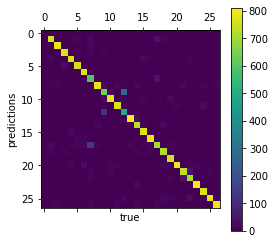

In [38]:
acc, true, pred = test_network(model_double_layer, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_double_layer.classes), pred, true)

(64, 8, 5, 5)


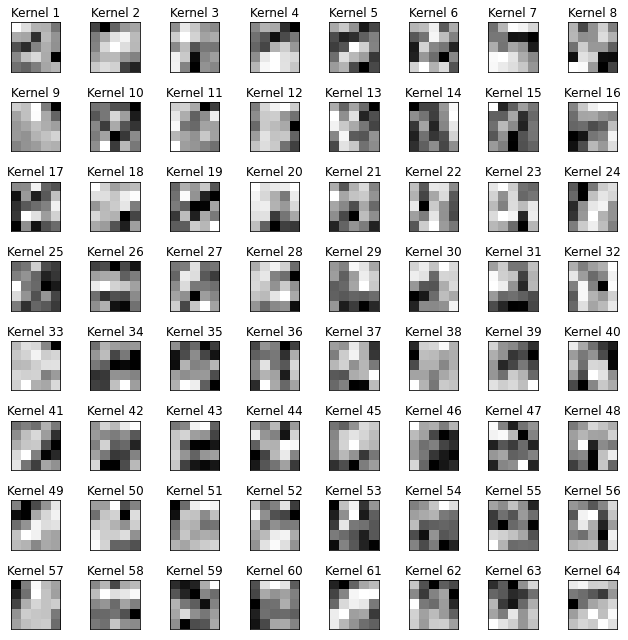

In [39]:
# first, extract the weights from the learned model
conv2wts = model_double_layer.layers[3].weight.data.numpy()
print(conv2wts.shape)

# then, visualize them!
_, axes = plt.subplots(8, 8, figsize=(9,9))
kernel = 0
for i in range(8):
    for j in range(8):
        img = conv2wts[kernel][0]
        axes[i,j].matshow(img, cmap='gray')
        kernel += 1
        title = 'Kernel ' + str(kernel)
        axes[i,j].set_title(title)
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

### 2b) Increasing the Kernel Size

In [40]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [41]:
# Given model, get optimized input for each character
def get_optimized_inputs(model, nepochs = 10000):
    targets = torch.arange(len(model.classes)).long()
    optimized_inputs = {}

    for t in targets:
        # train input
        input_model = OptimizeInput(model)
        optimizer = torch.optim.Adam(input_model.parameters(), lr=.01)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(nepochs):
            optimizer.zero_grad()
            outputs = input_model()
            loss = criterion(outputs, t.reshape(1))
            loss.backward()
            optimizer.step()
        print("finished %s with %0.5f loss" % (model.classes[t], loss.item()), end = "\t")
        optimized_inputs[model.classes[t]] = input_model.optimized_input.detach().numpy().reshape((28, 28))
        
        # test input
        tensor = torch.Tensor(optimized_inputs[model.classes[t]].reshape(1, 1, 28, 28))
        with torch.no_grad():
            output = model(tensor)
        prob = output.squeeze().detach().numpy()
        pred = model.classes[torch.argmax(output, dim=1)]
        print(f"Expected: {model.classes[t]}. Predicted: {pred}.")
    return optimized_inputs

In [42]:
optimized_inputs = get_optimized_inputs(model2, nepochs=1000)

finished N/A with 0.00594 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00008 loss	Expected: a. Predicted: a.
finished b with 0.00009 loss	Expected: b. Predicted: b.
finished c with 0.00001 loss	Expected: c. Predicted: c.
finished d with 0.00003 loss	Expected: d. Predicted: d.
finished e with 0.00007 loss	Expected: e. Predicted: e.
finished f with 0.00004 loss	Expected: f. Predicted: f.
finished g with 0.00011 loss	Expected: g. Predicted: g.
finished h with 0.00002 loss	Expected: h. Predicted: h.
finished i with 0.00000 loss	Expected: i. Predicted: i.
finished j with 0.00000 loss	Expected: j. Predicted: j.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



finished k with 0.00000 loss	Expected: k. Predicted: k.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/k7/zz5h09l90lz91rrnxkcsyfv00000gn/T/ipykernel_93330/4281044049.py", line 1, in <module>
    optimized_inputs = get_optimized_inputs(model2, nepochs=1000)
  File "/var/folders/k7/zz5h09l90lz91rrnxkcsyfv00000gn/T/ipykernel_93330/396317238.py", line 12, in get_optimized_inputs
    optimizer.zero_grad()
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/optim/optimizer.py", line 209, in zero_grad
    if p.grad is not None:
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/_tensor.py", line 1001, in grad
    @property
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/intera

TypeError: object of type 'NoneType' has no len()

In [ ]:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
fig, axes = plt.subplots(4, 7, figsize=(9,9))
letter = 0
for i in range(4):
    for j in range(7):
        img = optimized_inputs[letters[letter]].T
        axes[i,j].matshow(img, cmap='gray')
        title = 'opt ' + str(letters[letter])
        letter += 1
        axes[i,j].set_title(title)
        if letter > 25: break
fig.delaxes(axes[3,5])
fig.delaxes(axes[3,6])
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()    

In [ ]:
class letterCNNBigKernel(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(8,8), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(800, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [ ]:
model_big_kernel = letterCNNBigKernel(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_big_kernel.parameters(), lr=1e-3)
train_network(model_big_kernel, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_big_kernel, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_big_kernel.classes), pred, true)

In [ ]:
optimized_inputs = get_optimized_inputs(model_big_kernel, nepochs=1000)

In [ ]:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
fig, axes = plt.subplots(4, 7, figsize=(9,9))
letter = 0
for i in range(4):
    for j in range(7):
        img = optimized_inputs[letters[letter]].T
        axes[i,j].matshow(img, cmap='gray')
        title = 'opt ' + str(letters[letter])
        letter += 1
        axes[i,j].set_title(title)
        if letter > 25: break
fig.delaxes(axes[3,5])
fig.delaxes(axes[3,6])
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()    

In [ ]:
class letterCNNBiggerKernel(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(11,11), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(648, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [ ]:
model_bigger_kernel = letterCNNBiggerKernel(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bigger_kernel.parameters(), lr=1e-3)
train_network(model_bigger_kernel, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_bigger_kernel, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_bigger_kernel.classes), pred, true)

In [ ]:
optimized_inputs = get_optimized_inputs(model_bigger_kernel, nepochs=1000)

In [ ]:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
fig, axes = plt.subplots(4, 7, figsize=(9,9))
letter = 0
for i in range(4):
    for j in range(7):
        img = optimized_inputs[letters[letter]].T
        axes[i,j].matshow(img, cmap='gray')
        title = 'opt ' + str(letters[letter])
        letter += 1
        axes[i,j].set_title(title)
        if letter > 25: break
fig.delaxes(axes[3,5])
fig.delaxes(axes[3,6])
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()    